In [1]:
import sys
import site

sys.path.append('/mnt/home/agabrielpillai/.local/lib/python3.6/site-packages/')
site.addsitedir('/mnt/home/agabrielpillai/') 
site.addsitedir('/mnt/home/agabrielpillai/scripts/') 

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

import h5py

import astropy

import yt
import ytree
import yt.units.yt_array as yta

import illustris_sam as ilsam

import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

import scipy.integrate as integrate
from scipy.integrate import quad, nquad
from scipy import special
from scipy import optimize
import math

In [3]:
def g(z):                           #eq.28 in RP+2016
    a  = cosmo.scale_factor(z)
    om = cosmo.Om(z)
    ol = cosmo.Ode(z)

    return (2 / 5) * (om * a) / (np.power(om , 0.571428571) - ol + (1 + 0.5*om)*(1 + 0.014285714*ol))

def D(z):
    return g(z) / g(0)

def sigma(M_vir):
    y = 1e12 / M_vir
    
    term1 = 17.967209*y**0.409964
    term2 = 1 + 1.179455*y**0.210397 + 6.192103*y**0.320073

    return term1/term2

## these numbers are different from the published values, provided by Aldo in private communication.

def f(M_vir, z):  # following RP+2016
    A = lambda x: 0.143873 - 0.0112026*x  + 0.00253025*(x**2)
    a = lambda x: 1.35053  + 0.0681399*x  - 0.00593122*(x**2)
    b = lambda x: 3.11271  - 0.0770555*x  - 0.0134007*(x**2)
    c = lambda x: 1.1869   + 0.00875954*x - 0.000739608*(x**2)

    sig = sigma(M_vir) * D(z)

    return A(z) * (((sig / b(z))**(-a(z))) + 1) * np.exp(-c(z) / (sig**2))

def diff_sigma(M_vir):
    return (np.log(1.0 / sigma(1.002 * M_vir)) - np.log(1.0 / sigma(0.998*M_vir))) / (np.log(1.002*M_vir) - np.log(0.998*M_vir))
 
def phi_vir_dm(M_vir,z):
    rho_m = (cosmo.Om(0) * cosmo.critical_density(0).to(u.solMass/(u.Mpc)**3)).value / cosmo.h**2
    return f(M_vir,z) * (rho_m / M_vir**2) * abs(diff_sigma(M_vir)) * (M_vir / np.log10(np.exp(1.)))

cosmo = FlatLambdaCDM(Om0 = 0.307, Ob0 = 0.048, H0 = 67.8)

In [4]:
def refData(fname):
    fpath = '/mnt/home/agabrielpillai/calibration_data/mini_repo/'
    d = np.genfromtxt(fpath+fname)
    df = pd.DataFrame(data=d)
    return(df)


def axParams(ax, xlab, ylab):
    ax.set_xlabel(xlab, fontsize='x-large')
    ax.set_ylabel(ylab, fontsize='x-large')
    ax.legend()
    
        

In [5]:
def subvolumeList(n):
    subvolume_list = []

    for i in range(n):
        for j in range(n):
            for k in range(n):
                subvolume_list.append([i, j, k])

    return subvolume_list

In [6]:
galprop_fields = ['GalpropMstar', 'GalpropMhalo', 'GalpropMBH', 'GalpropMHI', 
                  'GalpropMH2', 'GalpropZstar', 'GalpropSatType']

basePath = '/mnt/ceph/users/agabrielpillai/tng-sam/'

In [7]:
m_DM_100 = 	0.000599968882709879 * 1e10 / 0.6774

In [8]:
subhalos_100 = ilsam.groupcat.load_snapshot_subhalos(basePath + 'L75n1820TNG/', 99, subvolumeList(5), fields=galprop_fields)
subhalos_300 = ilsam.groupcat.load_snapshot_subhalos(basePath + 'L205n2500TNG/', 99, subvolumeList(7), fields=galprop_fields)
subhalos_50 = ilsam.groupcat.load_snapshot_subhalos(basePath + 'L35n2160TNG/', 99, subvolumeList(6), fields=galprop_fields)

KeyboardInterrupt: 

In [ ]:
def SAMDF(subhalos):
    df = pd.DataFrame()
    df['mstar'] = subhalos['GalpropMstar']
    df['mhalo'] = subhalos['GalpropMhalo']
    df['mHI'] = subhalos['GalpropMHI']
    df['mH2'] = subhalos['GalpropMH2']
    df['mBH'] = subhalos['GalpropMBH']
    df['Zstar'] = subhalos['GalpropZstar']
    df['sat_type'] = subhalos['GalpropSatType']
    return df

In [223]:
m_DM_100 = 	0.000599968882709879 * 1e10 / 0.6774
m_DM_300 = 0.0047271638660809 * 1e10 / 0.6774
m_DM_50 = 3.6475561e5 / 0.6774 

In [224]:
tng_sam_100 = SAMDF(subhalos_100)
tng_sam_100_centrals = tng_sam_100[tng_sam_100['sat_type'] == 0].reset_index(drop=True)

tng_sam_300 = SAMDF(subhalos_300)
tng_sam_300_centrals = tng_sam_300[tng_sam_300['sat_type'] == 0].reset_index(drop=True)

tng_sam_50 = SAMDF(subhalos_50)
tng_sam_50_centrals = tng_sam_50[tng_sam_50['sat_type'] == 0].reset_index(drop=True)

We then load the appropriate TNG files.

In [225]:
save_results_to = '/mnt/home/agabrielpillai/plots/08-20-20/calibration/'

In [226]:
msmh = refData('msmh_z0.0.dat')

gsmf_moustakas13 = refData('gsmf-moustakas13.dat')
gsmf_baldry12 = refData('gsmf-baldry12.dat')
gsmf_bernardi13 = refData('gsmf-bernardi13.serexp.dat')

zstar_gal = refData('stellarmet.gallazzi.dat')

fgas_peeples = refData('peeples14.fgas.dat')
fgas_boselli = refData('fgas_boselli14.dat')

In [227]:
c_50 = (255 / 255, 193 /255, 7 / 255)
c_100 = (216 / 255, 27/255, 96/255)
c_300 = (30 / 255, 136 /255, 229 / 255)

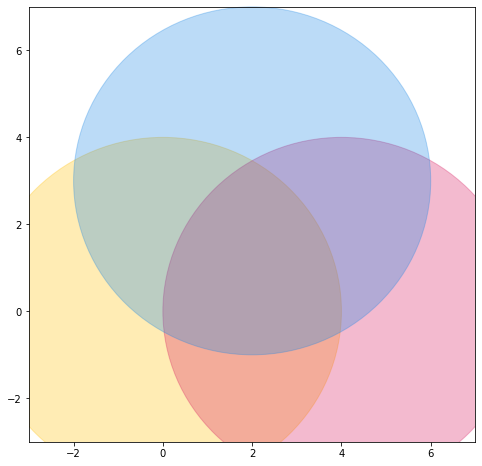

In [228]:


fig, ax = plt.subplots(1, 1, figsize=(8, 8)) # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

plt.xlim(-3, 7)
plt.ylim(-3, 7)
ax.add_artist(plt.Circle((0, 0), 4, color=c_50 , alpha = 0.3))
ax.add_artist(plt.Circle((4, 0), 4, color=c_100, alpha = 0.3))
ax.add_artist(plt.Circle((2, 3), 4, color=c_300, alpha = 0.3, clip_on=False))

fig.savefig('plotcircles.png')

In [229]:
gsmf_baldry12

,0,1,2,3,4
0,6.25,0.5,31.100,21.600,9.0
1,6.75,0.5,18.100,6.600,19.0
2,7.10,0.2,17.900,5.700,18.0
3,7.30,0.2,43.100,8.700,46.0
4,7.50,0.2,31.600,9.000,51.0
5,7.70,0.2,34.800,8.400,88.0
6,7.90,0.2,27.300,4.200,140.0
7,8.10,0.2,28.300,2.800,243.0
8,8.30,0.2,23.500,3.000,282.0
9,8.50,0.2,19.200,1.200,399.0


## Stellar Mass Function

In [230]:
def MassFunction(ax, mass, volume, c, l, mark, th):
    mass = np.log10(mass[mass > 0])
    
    phi, edg = np.histogram(mass, bins=25, range=(th, mass.max()))
    phi_i = phi
    dlogM = edg[1] - edg[0] # uniform bin size
    centers = edg[0:-1] + dlogM /  2.0 # x-axis bin centers to plot Phi against; these are log10    
    phi_norm = phi / volume / dlogM 
    ax.plot(centers, np.log10(phi_norm), color = c, label=l, lw = 8, alpha = 1, ls=mark)
    #plt.plot(10**centers, phi_norm, c=c, lw = 3)

In [231]:
#     ax.errorbar(x=gsmf_bernardi13[0], y=gsmf_bernardi13[1], yerr=gsmf_bernardi13[2], 
#                 fmt='s', c='black', capsize=3, label='Bernardi+13')
#     ax.errorbar(x=gsmf_moustakas13[3][0:32], y=gsmf_moustakas13[5][0:32], 
#                  yerr=[gsmf_moustakas13[6][0:32], gsmf_moustakas13[7][0:32]], 
#                   ms=10, fmt='^', c='black', capsize=3, label='Moustakas+13')
#     ax.errorbar(x=gsmf_baldry12[0], y=np.log10(gsmf_baldry12[2] * 10**-3), yerr=gsmf_baldry12[0] * 0, 
#                 fmt='o', c='black', capsize=3, ms=10, label='Baldry+12')
def SMF(ax):
    MassFunction(ax, tng_sam_50['mstar'] * 1e9, (35 / 0.6774)**3, c_50, 'SAM (TNG50)', '-', 6)
    MassFunction(ax, tng_sam_300['mstar'] * 1e9, (205 / 0.6774)**3, c_300, 'SAM (TNG300)', '-', 6)
    MassFunction(ax, tng_sam_100['mstar'] * 1e9, (75 / 0.6774)**3, c_100, 'SAM (TNG100)', '-', 6)

    ax.errorbar(x=gsmf_bernardi13[0], y=gsmf_bernardi13[1], yerr=gsmf_bernardi13[2], 
                fmt='s', c='black', capsize=3, label='Bernardi+13')
    ax.errorbar(x=gsmf_moustakas13[3][0:32], y=gsmf_moustakas13[5][0:32], 
                 yerr=[gsmf_moustakas13[6][0:32], gsmf_moustakas13[7][0:32]], 
                  ms=10, fmt='^', c='black', capsize=3, label='Moustakas+13')
    ax.errorbar(x=gsmf_baldry12[0], y=np.log10(gsmf_baldry12[2] * 10**-3), yerr=gsmf_baldry12[0] * 0, 
                fmt='o', c='black', capsize=3, ms=10, label='Baldry+12')
    
    ax.set_ylim((-6, -0.5))
    ax.set_xlim(7, 12.25)
    axParams(ax, '$log_{10} m_{*} [M_{\odot}]$', '$\Phi$')
    ax.legend()

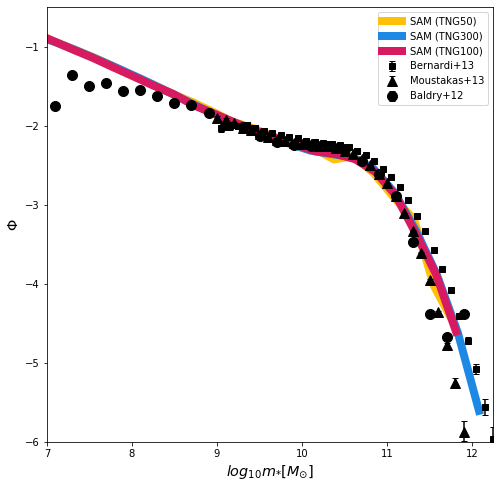

In [232]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

SMF(ax)

# $[M_\odot]$ [$< 2 r_{stars, 1/2}$]
plt.savefig(save_results_to + 'SMF.png', dpi = 300)

## Halo Mass Function

In [233]:
M_vir_list = np.linspace(start = 7, stop = 16, num = 2000) 
M_vir_list = (10**M_vir_list )

phi = [ phi_vir_dm(_, 0) for _ in M_vir_list ]
# phi_3 = [ phi_vir_dm(_, 3) for _ in M_vir_list ]
# phi_6 = [ phi_vir_dm(_, 6) for _ in M_vir_list ]

In [234]:
def HMF(ax):
    ax.plot(np.log10(M_vir_list / 0.7), np.log10(np.array(phi)*(0.7)**3), color='black', ls='--', label='z = 0 (LYung)', lw= 3, zorder=10)
    MassFunction(ax, 1e9*tng_sam_300_centrals['mhalo'], (205 / 0.6774)**3, c_300, 'SAM (TNG300)', '-', np.log10(100*m_DM_300))
    MassFunction(ax, 1e9*tng_sam_100_centrals['mhalo'], (75 / 0.6774)**3, c_100, 'SAM (TNG100)', '-', np.log10(100*m_DM_100))
    MassFunction(ax, 1e9*tng_sam_50_centrals['mhalo'], (35 / 0.6774)**3, c_50, 'SAM (TNG50)', '-', np.log10(100*m_DM_50))
    axParams(ax, '$log_{10} m_{halo}$ $[M_\odot]$', '$\Phi$')
    plt.legend()
    ax.set_ylim(-7, 1.5)
    ax.set_xlim(8, 15.4)

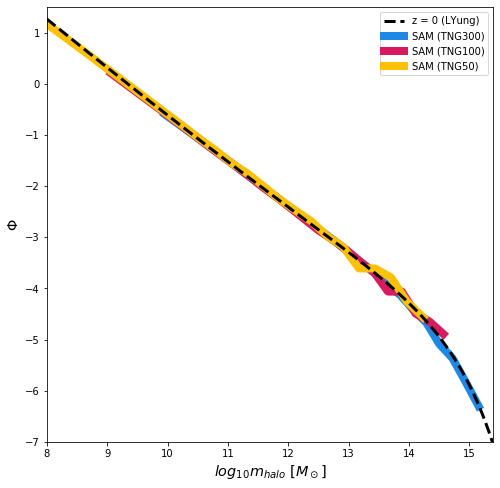

In [235]:
fig, ax = plt.subplots(figsize = (8, 8))
HMF(ax)

plt.savefig(save_results_to + 'HMF.png', dpi = 300)


We specify that we are looking at halos that are at redshift 0.

 We now calculate $r_{comp}$

In [236]:
def medianPlot(ax, color, lab, th, q1, q2, q, nbin):
    h = np.empty((0,4), int)

    q1 = q1[q2.notnull()]
    q2 = q2[q2.notnull()]
    
    #print(sum(np.isinf(q2)))
    q1 = q1[~np.isinf(q2)]
    q2 = q2[~np.isinf(q2)]

    if (th > 0): 
        q2 = q2[q1 > th] # index y axis quantity based on q1 threshold
        q1 = q1[q1 > th] # index x axis quantity based on threshold 

    f = np.linspace(q1.min(), q1.max(), nbin) #q1 range linspace
    
    w_bin = f[1] - f[0] # width of the bin
    f = f + w_bin / 2 # shift over linspace by half width
    
    g = [] # empty array for holding statistics 
    
    for i in range(0, len(f) - 1):          
        lb = np.array(q1 > (f[i] - w_bin / 2)) + 0 # lower bound
        hb = np.array(q1 < (f[i] + w_bin / 2)) + 0 # upper bound

        s = q2[(lb + hb) == 2]
        s = s[~np.isnan(s)] # remove NaNs

        if (s.shape[0] < 1):
            next
        
        if (s.shape[0] > 0):
            g.append(np.array([f[i], 
                      np.percentile(s, 15.9), 
                      np.percentile(s, 50), 
                      np.percentile(s, 84.1)])) # append stats

    g = np.array(g)

    if q:
        ax.fill_between((g[:,0]), np.log10(g[:,1]), np.log10(g[:,3]), color=color, alpha = 0.4)
    else:
        ax.plot(g[:,0], np.log10(g[:,1]), c = color, ls = '--', lw=8)
        ax.plot(g[:,0], np.log10(g[:,3]), c = color, ls = '--', lw=8)
    
    ax.plot(g[:,0], np.log10(g[:,2]), c = color, label = lab, lw =8)


## SMHM

In [252]:
#     ax.errorbar(x=msmh[0], y=np.log10(10**msmh[6] / 10**msmh[0]), 
#              yerr=[np.log10(10**msmh[7] / 10**msmh[0]) - np.log10(10**msmh[6] / 10**msmh[0]), 
#                    np.log10(10**msmh[6] / 10**msmh[0]) - np.log10(10**msmh[5] / 10**msmh[0])], 
#             fmt='o', c='black', capsize=3, ms=8, label='Rodriguez-Puebla+17', zorder=10)
    
def MvirMstar200(ax):
    medianPlot(ax, c_50, 'SAM (TNG50)', np.log10(100*m_DM_50), np.log10(1e9*tng_sam_50_centrals['mhalo']), 
               ((1e9*tng_sam_50_centrals['mstar']) / (1e9*tng_sam_50_centrals['mhalo'])), 0, 25)
    medianPlot(ax, c_100, 'SAM (TNG100)', np.log10(100*m_DM_100), np.log10(1e9*tng_sam_100_centrals['mhalo']), 
                ((1e9*tng_sam_100_centrals['mstar']) / (1e9*tng_sam_100_centrals['mhalo'])), 0, 25)
    medianPlot(ax, c_300, 'SAM (TNG300)', np.log10(100*m_DM_300), np.log10(1e9*tng_sam_300_centrals['mhalo']), 
                ((1e9*tng_sam_300_centrals['mstar']) / (1e9*tng_sam_300_centrals['mhalo'])), 0, 25)
    ax.minorticks_on()
    ax.fill_between(msmh[0], np.log10(10**msmh[5] / 10**msmh[0]), np.log10(10**msmh[7] / 10**msmh[0]), color='black', alpha = 0.4)

    ax.scatter(x=msmh[0], y=np.log10(10**msmh[6] / 10**msmh[0]), c='black', s=40, label='Rodriguez-Puebla+17', zorder=10)
    axParams(ax, '$log_{10} m_{vir}$ $[M_\odot]$', r'$log_{10}(\dfrac{m_{*}}{m_{vir}})$')
    plt.tight_layout()
    ax.set_ylim(-4.5, -1.1)
    ax.set_xlim(9.5, 15.25)
    ax.legend()

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10


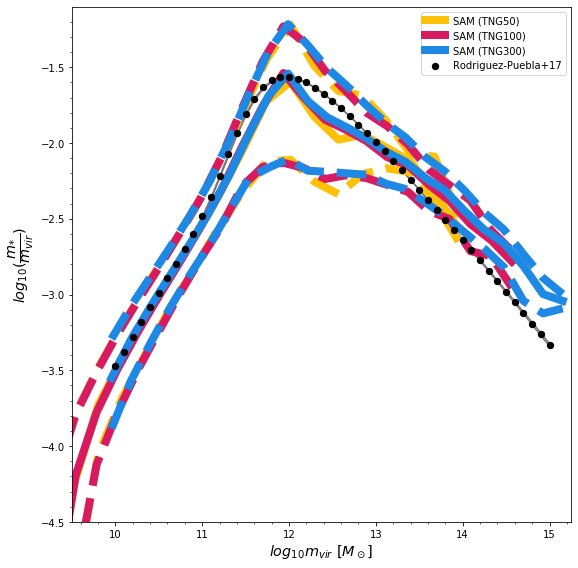

In [253]:
fig, ax = plt.subplots(figsize = (8, 8))
MvirMstar200(ax)
plt.savefig(save_results_to + 'SMHM.png', dpi = 300)

## $m_{hot}$

In [241]:
def R(a, b, C, logMtr, m):
    return (C / ((10**m / 10**logMtr)**a + (10**m / 10**logMtr)**b))

In [242]:
#     ax.errorbar(x=xCat, y=(rGasCat), yerr=rGasCatErr, 
#                 fmt='^', c='black', capsize=3, ms=10, label='Catinella+18', zorder=10)
#     ax.errorbar(x=mbin, y=np.log10(Rgas), yerr=sigRgas, 
#                 fmt='o', c='black', capsize=3, ms=10, label='Calette+18', zorder=10)
#     axParams(ax, '$log_{10} m_{*}$ $[M_\odot]$', '$log_{10} (m_{cold} / m_{*}) =log_{10} ((m_{H_{I}} + m_{H_{2}}) / m_{*})$')
def McoldvMstar(ax):
    mbin = np.arange(7.3, 11.2, 0.2)

    RHI = R(0.21, 0.67, 0.98, 9.24, mbin)
    RH2 = R(-0.07, 0.47, 0.19, 9.24, mbin)
    Rgas = R(0.18, 0.61, 1.69, 9.20, mbin)
    Rgas = 1.4*(RHI + RH2)
        
    xCat = np.array([9.16, 9.44, 9.75, 10.05, 10.34, 10.65, 10.95, 11.21])
    rGasCat = np.array([0.098, -0.136, -0.509, -0.518, -0.817, -0.958, -1.190, -1.328])
    rGasCatErr = np.array([0.064, 0.077, 0.076, 0.062, 0.055, 0.048, 0.048, 0.064])

    sigRgas = (1 / (RHI + RH2) * ((0.53**2)*RHI**2 + (0.58**2)*RH2**2)**(0.5))
    
    sam_50_q1 = 1e9*tng_sam_50_centrals['mstar']
    sam_50_q2 = (1e9*(tng_sam_50_centrals['mHI'] + tng_sam_50_centrals['mH2'])) / (1e9*tng_sam_50_centrals['mstar'])    
    medianPlot(ax, c_50, 'SAM (TNG50)', 6, np.log10(sam_50_q1), (sam_50_q2), 0, 20)
    
    sam_100_q1 = 1e9*tng_sam_100_centrals['mstar']
    sam_100_q2 = (1e9*(tng_sam_100_centrals['mHI'] + tng_sam_100_centrals['mH2'])) / (1e9*tng_sam_100_centrals['mstar'])    
    medianPlot(ax, c_100, 'SAM (TNG100)', 6, np.log10(sam_100_q1), (sam_100_q2), 0, 20)
    
    sam_300_q1 = 1e9*tng_sam_300_centrals['mstar']
    sam_300_q2 = (1e9*(tng_sam_300_centrals['mHI'] + tng_sam_300_centrals['mH2'])) / (1e9*tng_sam_300_centrals['mstar'])    
    medianPlot(ax, c_300, 'SAM (TNG300)', 6, np.log10(sam_300_q1), (sam_300_q2), 0, 20)
    
    ax.scatter(xCat, rGasCat, c='black', label='Catinella+18')
    ax.fill_between(xCat, rGasCat - rGasCatErr, rGasCat + rGasCatErr, color='black', alpha = 0.4)
    ax.scatter(mbin, np.log10(Rgas), c='black', label='Calette+18')
    ax.fill_between(mbin, np.log10(Rgas) - sigRgas, np.log10(Rgas) + sigRgas, color='black', alpha = 0.4)

    axParams(ax, '$log_{10} m_{*}$ $[M_\odot]$', '$log_{10} (m_{cold} / m_{*}) =log_{10} ((m_{H_{I}} + m_{H_{2}}) / m_{*})$')
    ax.set_ylim(-4, 1.5)
    ax.set_xlim(7, 12.25)

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


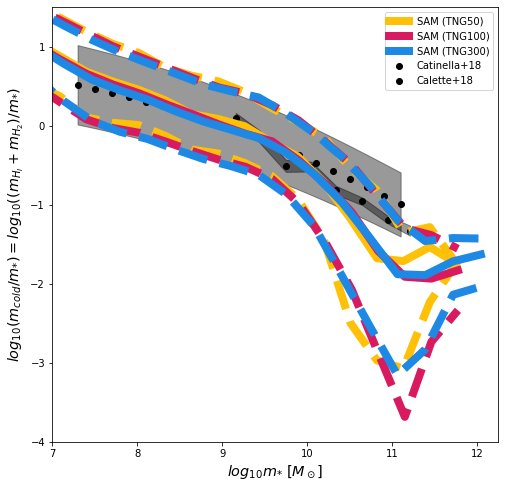

In [244]:

fig, ax = plt.subplots(1, 1, figsize = (8, 8))
McoldvMstar(ax)
plt.savefig(save_results_to + 'mcold_mstar.png', dpi = 300)



##  $Z_{*}$ v. $m_{*}$

In [254]:
#     ax.errorbar(x=zstar_gal[0], y=zstar_gal[1], yerr=[zstar_gal[1] - zstar_gal[2], zstar_gal[3] - zstar_gal[1]], 
#             fmt='o', c='black', capsize=3, ms=10, label='Gallazzi+05', zorder=10)
def Zstar(ax):
    ax.scatter(zstar_gal[0], zstar_gal[1], c='black', label='Catinella+18')
    ax.fill_between(zstar_gal[0],  zstar_gal[2],  zstar_gal[3] , color='black', alpha = 0.4)

    mbin = np.arange(6.0, 9.4, 0.2)
    kirby11 = -1.69 + 0.3*(mbin-6.0)

    ax.scatter(mbin, kirby11, color='black', label='Kirby+11', zorder=10, s=80, marker='^')
    medianPlot(ax, c_50, 'SAM (TNG50)', 7, np.log10(1e9*tng_sam_50_centrals['mstar']), 
               ((1e9*tng_sam_50_centrals['Zstar']) / (1e9*tng_sam_50_centrals['mstar'])), 0, 10)
    medianPlot(ax, c_100, 'SAM (TNG100)', 7, np.log10(1e9*tng_sam_100_centrals['mstar']), 
               ((1e9*tng_sam_100_centrals['Zstar']) / (1e9*tng_sam_100_centrals['mstar'])), 0, 10)
    medianPlot(ax, c_300, 'SAM (TNG300)', 7, np.log10(1e9*tng_sam_300_centrals['mstar']), 
               ((1e9*tng_sam_300_centrals['Zstar']) / (1e9*tng_sam_300_centrals['mstar'])), 0, 10)

    ax.set_xlim(8, 12)
    ax.set_ylim(-1.5, 0.4)
    axParams(ax, '$log_{10} m_{*}$ $[M_\odot]$', '$log_{10} Z_{*}$ $[Z_{\odot}]$')

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


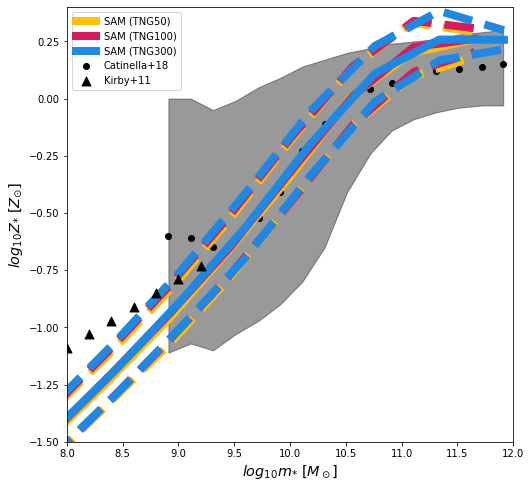

In [255]:
fig, ax = plt.subplots(figsize = (8, 8))
Zstar(ax)
plt.savefig(save_results_to + 'Zstar_mstar.png', dpi = 300)


### $m_{BH}$ v. $m_{bulge}$

In [256]:
def MBHvMbulge(ax):
    medianPlot(ax, c_50, 'SAM (TNG50)', 7,
               np.log10(1e9*tng_sam_50_centrals['mstar']), 
               ((1e9*tng_sam_50_centrals['mBH'])), 0, 10)
    medianPlot(ax, c_100, 'SAM (TNG100)', 7,
               np.log10(1e9*tng_sam_100_centrals['mstar']), 
               ((1e9*tng_sam_100_centrals['mBH'])), 0, 10)
    medianPlot(ax, c_300, 'SAM (TNG300)', 7,
               np.log10(1e9*tng_sam_300_centrals['mstar']), 
               ((1e9*tng_sam_300_centrals['mBH'])), 0, 10)

    mbin = np.arange(8, 12.01, 0.2)
    mbh_mcma = 8.56 + 1.34*(mbin-11.0)
    mbh_kh13 = 8.69 + 1.16*(mbin-11.0)
    ax.scatter(mbin, mbh_mcma, color = 'black', label='McConnel&Ma+?', marker='o', zorder=10, s=80)
    ax.scatter(mbin, mbh_kh13, color  = 'black', label='Kormendy+13', marker='^', zorder=10, s=80)
    axParams(ax, '$log_{10} m_{*}$ $[M_\odot]$', '$log_{10} m_{BH}$ $[M_{\odot}]$')
    plt.xlim(7.5, 12)

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


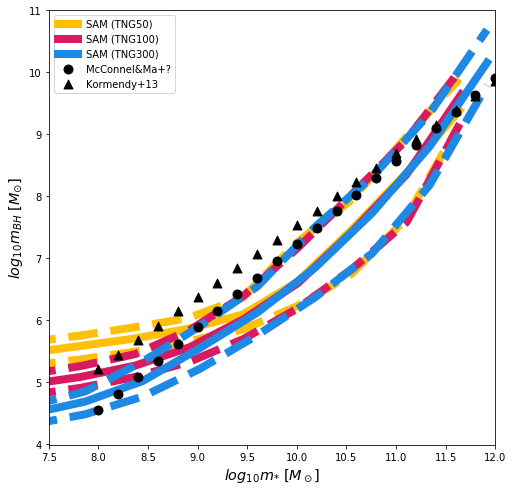

In [257]:
fig, ax = plt.subplots(figsize = (8, 8))
MBHvMbulge(ax)
plt.savefig(save_results_to + 'mBH_mstar.png', dpi = 300)


No handles with labels found to put in legend.
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:1

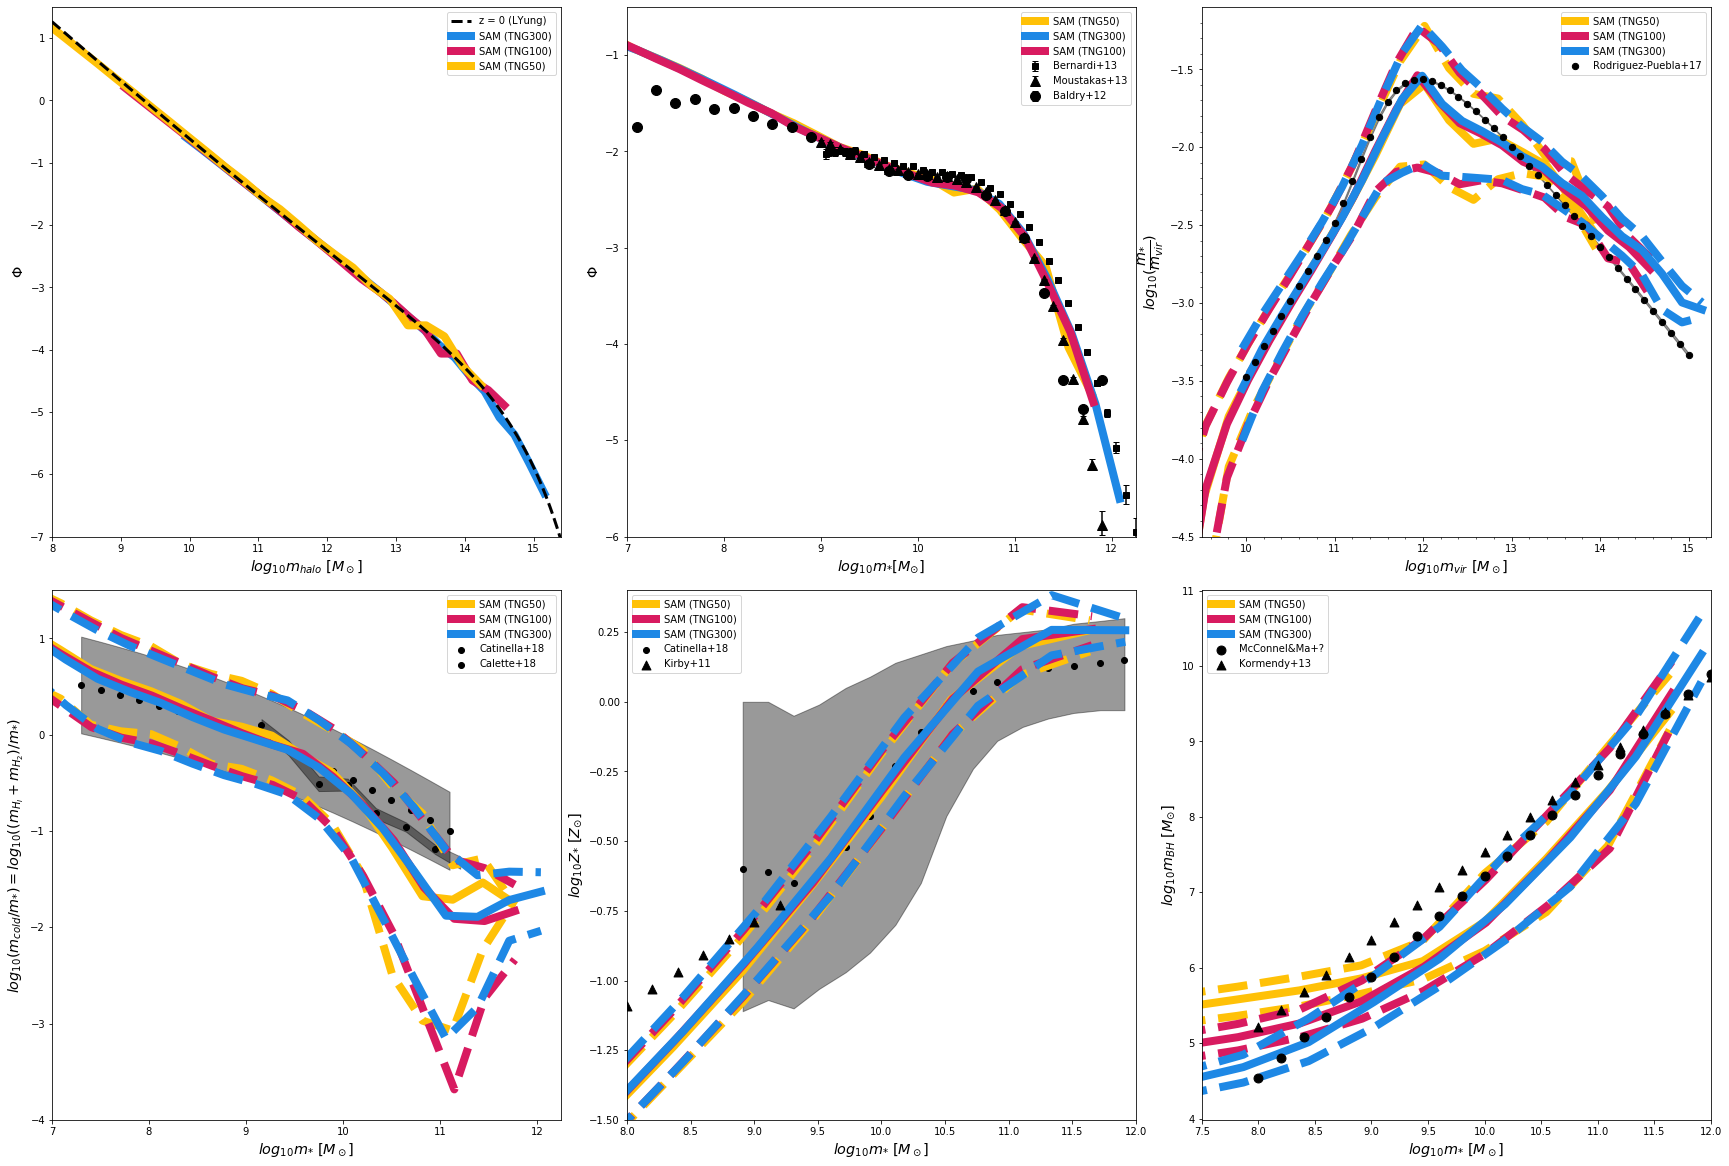

In [258]:
fig, ax = plt.subplots(2, 3, figsize = (24, 16))
HMF(ax[0][0])
SMF(ax[0][1])
MvirMstar200(ax[0][2])
McoldvMstar(ax[1][0])
Zstar(ax[1][1])
MBHvMbulge(ax[1][2])

plt.savefig(save_results_to + 'suite.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)